# `pyprop8`

This notebook illustrates some of the functionality of [`pyprop8`](https://github.com/valentineap/pyprop8). For full details, take a look at [the documentation](https://pyprop8.readthedocs.io).

In [48]:
import numpy as np

import pyprop8 as pp
from pyprop8.utils import rtf2xyz, make_moment_tensor,stf_trapezoidal

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d


In order to calculate synthetic seismograms, we need to set up: (i) an earth model, (ii) some information about where the 'instruments' are, and (iii) a description of the seismic source.

In `pyprop8`, the Earth is assumed to be a stack of (flat) layers, with the bottom layer extending to infinite depth. Each layer is described by its thickness, P- and S-wave velocities, and density; the last layer must have thickness `np.inf`.

In [59]:
#                                   Layer
#                                thickness Vp    Vs  Density
#                                    km   km/s  km/s  g/cm^3
model = pp.LayeredStructureModel([( 3.00, 1.80, 0.00, 1.02),
                                  ( 2.00, 4.50, 2.40, 2.57),
                                  ( 5.00, 5.80, 3.30, 2.63),
                                  (20.00, 6.50, 3.65, 2.85),
                                  (np.inf,8.00, 4.56, 3.34)]) 

# We can visualise the structure:
print(model)

------------------------------------------------------- z = 0.00 km
  vp = 1.80 km/s       FLUID        rho = 1.02 g/cm^3
------------------------------------------------------- z = 3.00 km
  vp = 4.50 km/s   vs = 2.40 km/s   rho = 2.57 g/cm^3
------------------------------------------------------- z = 5.00 km
  vp = 5.80 km/s   vs = 3.30 km/s   rho = 2.63 g/cm^3
------------------------------------------------------- z = 10.00 km
  vp = 6.50 km/s   vs = 3.65 km/s   rho = 2.85 g/cm^3
------------------------------------------------------- z = 30.00 km
  vp = 8.00 km/s   vs = 4.56 km/s   rho = 3.34 g/cm^3



Next we need to define the coordinates of the seismic receivers.  For this example, we generate random locations; of course, it would be straightforward to reproduce the distribution of stations in a real deployment. Here, we are specifying locations relative to a Cartesian kilometre grid with arbitrary origin (i.e. location (3,5) is 2km east and 1km north of location (1,4)). It is also possible to specify locations using latitude and longitude (option `geometry='spherical'`) - but beware; the seismograms will still be calculated assuming a flat Earth.

In [60]:
nstations = 10
stations_xy = np.random.uniform(-50,50,size=[nstations,2])

receivers = pp.ListOfReceivers(*stations_xy.T,depth=3) 

Finally we can define the seismic source. `pyprop8` assumes a point source, which can be described by a moment tensor and/or a force vector. The source location is assumed to be given relative to the same coordinate system as was used for the receivers.

In [61]:
strike = 180
dip = 0
rake = 0
M0=1E7
depth = 15
moment_tensor = rtf2xyz(make_moment_tensor(strike, dip, rake, M0, 0, 0))
point_force = np.zeros([3,1])
time = 0

source_x = 10
source_y = -5

source = pp.PointSource(source_x,source_y,depth,moment_tensor,point_force,time)

We now specify a source-time-function, by passing a callable function of frequency; a number of 'standard' options are available within `pyprop8.utils`.

In [64]:
stf = lambda w: stf_trapezoidal(w, 3, 6)

We can plot a map of the stations and source...

Text(0, 0.5, 'South-North')

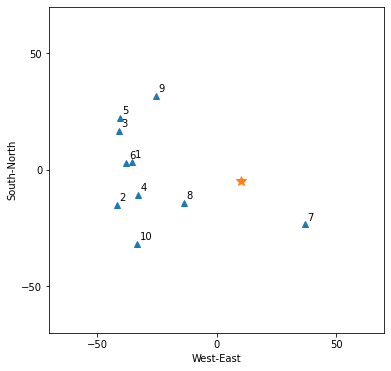

In [62]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(*stations_xy.T,marker='^',lw=0)
ax.plot([source.x],[source.y],marker='*',markersize=10)
for i in range(nstations):
    ax.text(stations_xy[i,0]+1,stations_xy[i,1]+1,"%i"%(i+1),verticalalignment='bottom',horizontalalignment='left')
ax.set_xlim(-70,70)
ax.set_ylim(-70,70)
ax.set_xticks([-50,0,50])
ax.set_yticks([-50,0,50])
ax.set_xlabel("West-East")
ax.set_ylabel("South-North")

...and we're ready to calculate some seimsograms! We set a sample spacing (i.e. the time interval, in seconds, between successive points in the seismogram) and fix the number of samples we wish to obtain. The first sample will correspond to the event time.

In [65]:
nt = 80
delta_t = 0.5
time, seismograms = pp.compute_seismograms(model,source,receivers,nt,delta_t,source_time_function=stf)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 48.43it/s]


We can plot individual (3-component) seismograms:

Text(0.5, 0, 'Time (s)')

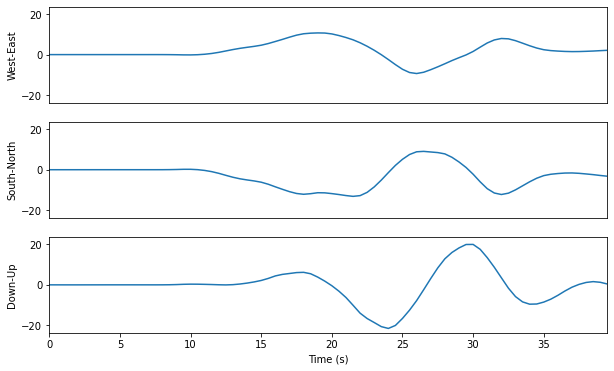

In [56]:
station_number = 1 # As given in the map above
irec = station_number - 1 # Because Python counts from 0
fig,ax = plt.subplots(3,figsize=(10,6))
ax[0].plot(time,seismograms[irec,0,:])
ax[1].plot(time,seismograms[irec,1,:])
ax[2].plot(time,seismograms[irec,2,:])
[a.set_xticks([]) for a in ax[:-1]]
[a.set_xlim(0,(nt-1)*delta_t) for a in ax]
ylim = abs(seismograms[irec,:,:]).max()*1.1
[a.set_ylim(-ylim,ylim) for a in ax]
ax[0].set_ylabel("West-East")
ax[1].set_ylabel("South-North")
ax[2].set_ylabel("Down-Up")
ax[-1].set_xlabel("Time (s)")

We can also make more complex figures, such as this visualisation of the particle motion:

Text(0.5, 0, 'Down-Up')

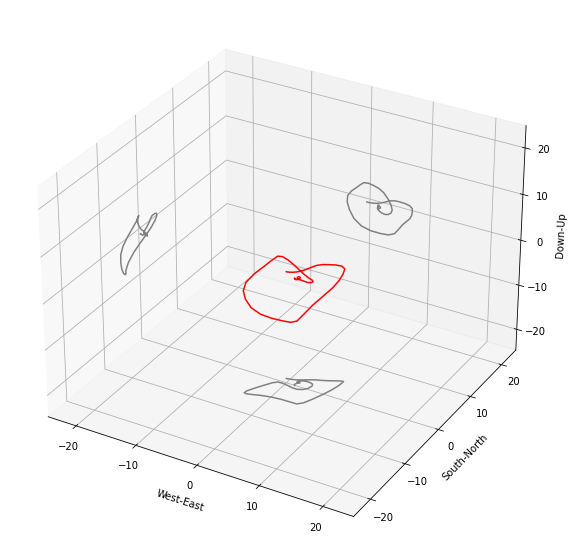

In [67]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(seismograms[irec,0,:],seismograms[irec,1,:],seismograms[irec,2,:],color='red')

ax.plot3D(seismograms[irec,0,:],np.full(nt,ylim),seismograms[irec,2,:],color='grey')
ax.plot3D(np.full(nt,-ylim),seismograms[irec,1,:],seismograms[irec,2,:],color='grey')
ax.plot3D(seismograms[irec,0,:],seismograms[irec,1,:],np.full(nt,-ylim),color='grey')

ax.set_xlim(-ylim,ylim)
ax.set_xlabel("West-East")
ax.set_ylim(-ylim,ylim)
ax.set_ylabel("South-North")
ax.set_zlim(-ylim,ylim)
ax.set_zlabel("Down-Up")

Depending on the source and receiver you have chosen, you will often see that the particle motion is not a closed loop: when the ground shaking stops, some permanent deformation remains. This is the 'static offset', and for real earthquakes it can often be measured using (e.g.) [InSAR](https://en.wikipedia.org/wiki/Interferometric_synthetic-aperture_radar) or GPS receivers. 

One way to simulate this would simply be to calculate long seismograms and determine the final displacement. However, `pyprop8` also provides the facility to compute static deformation directly. Again, we must specify an earth model, a set of receivers/observation points, and the seismic source. We will reuse the model and source from earlier, but define observation points as a regular polar grid.

In [91]:
receivers = pp.RegularlyDistributedReceivers(5,50,6,0,360,36,depth=3,x0=source.x,y0=source.y)

Plotting a map, we see this has created 6 concentric circles, each consisting of 36 receivers:

Text(0, 0.5, 'South-North')

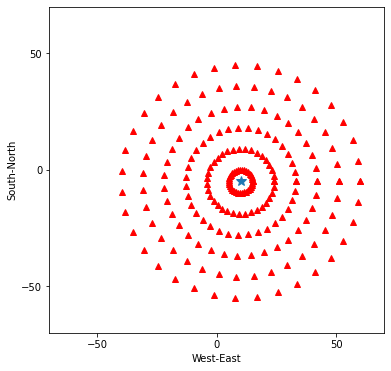

In [92]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(*receivers.as_xy(),marker='^',lw=0,color='r')
ax.plot([source.x],[source.y],marker='*',markersize=10)
ax.set_xlim(-70,70)
ax.set_ylim(-70,70)
ax.set_xticks([-50,0,50])
ax.set_yticks([-50,0,50])
ax.set_xlabel("West-East")
ax.set_ylabel("South-North")

For observation techniques such as InSAR, we only have data about the component of deformation along the line-of-site of a satellite. We therefore need to define the direction(s) in which we are making measurements

In [93]:
satellite_elevation = 30
satellite_azimuth = 0

elev = np.deg2rad(satellite_elevation)
azim = np.deg2rad(satellite_azimuth)
line_of_sight = np.array([np.sin(90-elev)*np.cos(azim),np.sin(90-elev)*np.sin(azim),np.cos(90-elev)])

In [94]:
line_of_sight

array([0.99826063, 0.        , 0.0589552 ])

In [95]:
static = pp.compute_static(model,source,receivers,los_vector=line_of_sight)

Text(0, 0.5, 'South-North')

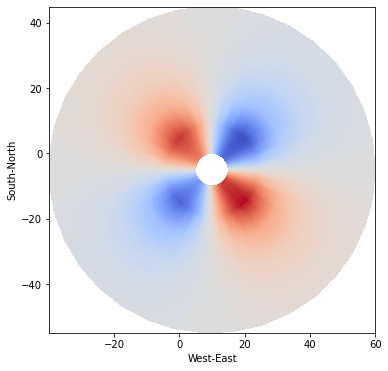

In [106]:
fig,ax = plt.subplots(1,figsize=(6,6))
ax.contourf(*receivers.as_xy(),static,100,cmap=plt.cm.coolwarm)
ax.set_aspect(1.)
ax.set_xlabel("West-East")
ax.set_ylabel("South-North")